In [1]:
from pathlib import Path
import random
import sys
from termcolor import colored

sys.path.append(str(Path("..").resolve()))
from src import *

# Assign a score to UV Maps to estimate the quality of the samples

##### ℹ️ This notebook requires Objaverse models in the `dataset/objaverse/objects` root folder. It also requires the `statistics.parquet`.

**A sample is considered good if the overall shape of the 3D object can be inferred from its UV map.** 
If this isn't the case, it would be quite difficult for the ControlNet to effectively condition the diffusion process.

In this notebook, we ask if we can devise a good scoring function to estimate the quality of a given UV map. We will not work at the pixel level, but will use the information available in the 3D model.

In [2]:
dataset = ObjaverseDataset3D()
stats = dataset.statistics
uids = stats[(stats["valid"])].index

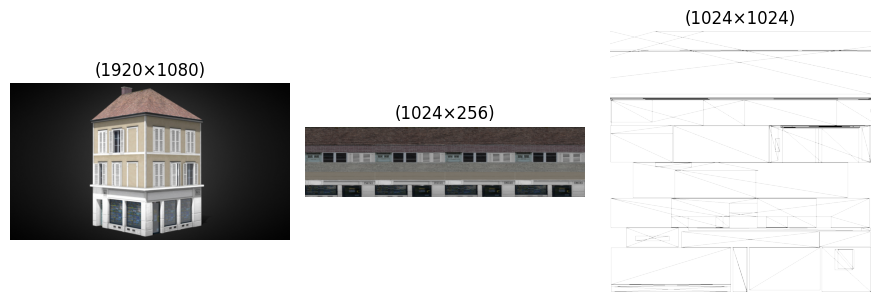

UV score: 52.09%


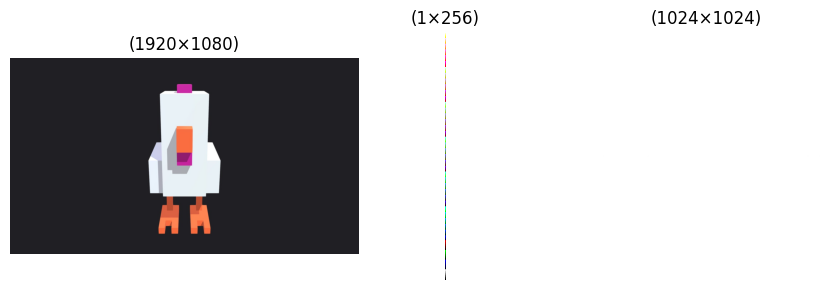

UV score: 0.00%


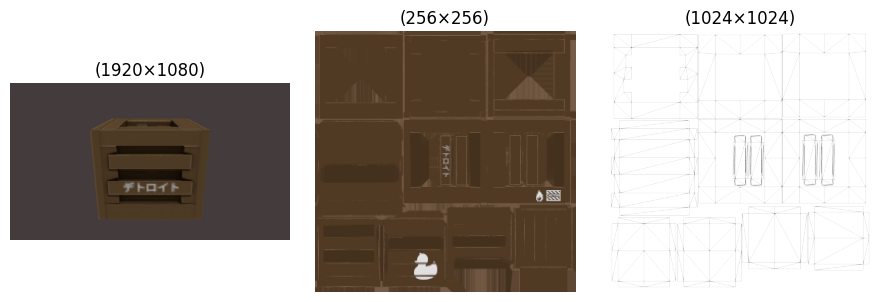

UV score: 88.64%


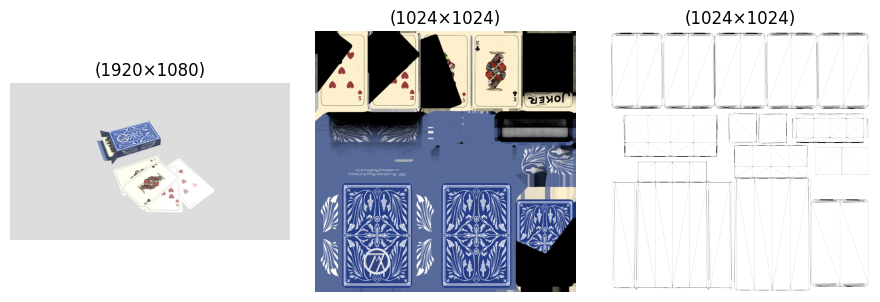

UV score: 83.64%


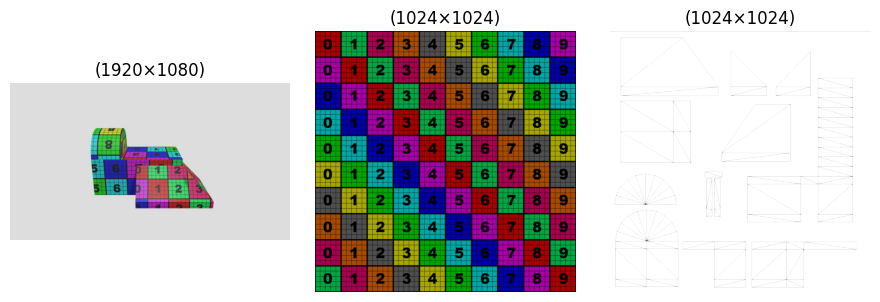

UV score: 89.83%


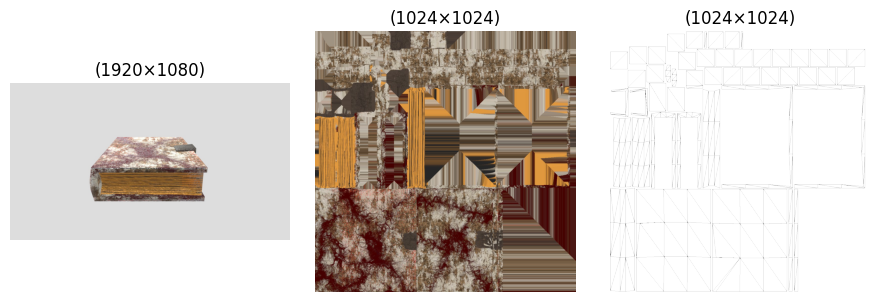

UV score: 99.76%


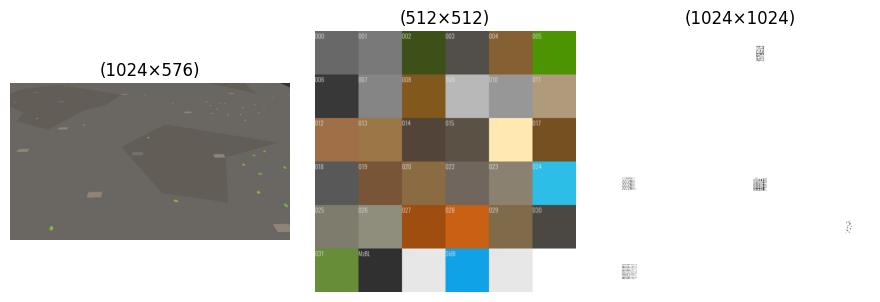

UV score: 39.76%


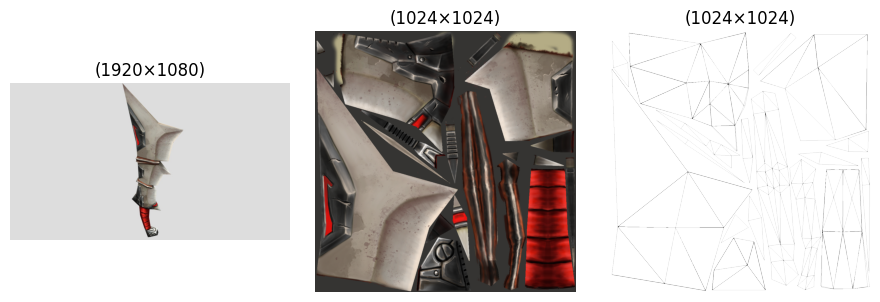

UV score: 90.82%


In [4]:
for uid in random.choices(uids, k=8):
    obj = dataset[uid]
    plot_images([obj.render, obj.textures[0], obj.draw_uv_map()], cols=3, size=3)
    uv_score = obj.uv_score
    print(f"UV score:", colored(f"{uv_score:.2%}", ["red", "yellow", "green"][int(uv_score / 0.333)]))

## Legacy Scoring criteria

1. **Continuity**
   UV islands that keep neighboring faces together make the shape much more reconstructible.

   * **Metric**:

     $$
       C \;=\; 1 \;-\; \frac{\#\text{cut-edges}}{\#\text{total mesh edges}}
     $$
   * Range: 0 (everything is a separate little island) to 1 (one single island).

2. **Distortion**
   Ideally, UV area should be locally proportional to 3D area (so shapes aren’t stretched or squashed).

   * For each face $f$, compute

     $$
       s_f = \frac{\text{area}_{\mathrm{UV}}(f)}{\text{area}_{3D}(f)}.
     $$
   * Then

     $$
       D = 1 - \frac{1}{1 + \sigma_s}
     $$

     where $\sigma_s$ is the standard deviation of all $s_f$.
   * Range: 0 (huge variation in per-face stretch) to approaching 1 (uniform stretch).

3. **Packing efficiency**
   How much of the 1024×1024 canvas is actually used by UV islands (vs. empty “wasted” space).

   * **Metric**

     $$
       P = \frac{\sum_f \text{area}_{\mathrm{UV}}(f)}{1024^2}.
     $$
   * Range: 0 (nothing packed) to 1 (no wasted space).

4. **Fragmentation**
   Penalize having many tiny islands (they’re “messy” to edit and imply cuts).

   * Let $N$ be number of islands, and $A_i$ each island’s area. Compute normalized entropy:

     $$
       F = 1 - \frac{-\sum_i \frac{A_i}{\sum A} \log\!\bigl(\frac{A_i}{\sum A}\bigr)}{\log N}.
     $$
   * Range: 0 (all islands equal small size – very fragmented) to 1 (one big island).


### Interpretation

* **$C$ near 1** means few UV seams: you’d see contiguous patches that hint at the whole form.
* **$D$ near 1** means low local stretch: volumes look “true,” so bumps and curves are faithfully represented.
* **$P$ near 1** means almost no wasted white space: a tidy, space-efficient layout.
* **$F$ near 1** means most area is in a few islands, not dozens of tiny scraps.

### Implementation

```python
    @property
    def uv_score(self, weights=(0.3, 0.25, 0.25, 0.2)):
        weights = (0.3, 0.25, 0.25, 0.2)
        assert self.has_one_mesh
        """
        Scores the UV layout of a Blender mesh object for readability and cleanliness.

        Args:
            weights (tuple): Weights for (continuity, distortion, packing, fragmentation).

        Returns:
            float: The combined score S between 0 and 1.
            dict: Individual component scores {"C", "D", "P", "F"}.
        """

        mesh = self.mesh.data
        bm = bmesh.new()
        bm.from_mesh(mesh)
        bm.edges.ensure_lookup_table()
        bm.faces.ensure_lookup_table()

        # Select UV layer
        uv_layer = bm.loops.layers.uv.active
        if uv_layer is None:
            raise ValueError("No UV layer found")

        # 1. Continuity: count cut edges (edges whose two adjacent faces map to different islands)
        total_edges = len(bm.edges)
        # Identify UV islands via flood fill
        island_idxs = {}
        current_island = 0
        tagged = {}

        def flood_fill(face, idx):
            stack = [face]
            while stack:
                f = stack.pop()
                for loop in f.loops:
                    tagged[loop[uv_layer]] = True
                island_idxs[f.index] = idx
                for edge in f.edges:
                    linked = [
                        lf.face for lf in edge.link_loops if loop[uv_layer] not in tagged or not tagged[loop[uv_layer]]
                    ]
                    for lf_face in linked:
                        if lf_face.index not in island_idxs:
                            stack.append(lf_face)

        for face in bm.faces:
            if face.index not in island_idxs:
                # clear tags
                # for l in bm.loops:
                #     l[uv_layer].tag = False
                flood_fill(face, current_island)
                current_island += 1

        # Now count cut edges: edges whose adjacent faces belong to different islands
        cut_edges = 0
        for edge in bm.edges:
            faces = edge.link_faces
            if len(faces) == 2:
                if island_idxs[faces[0].index] != island_idxs[faces[1].index]:
                    cut_edges += 1
        C = 1.0 - (cut_edges / total_edges) if total_edges > 0 else 0.0

        # 2. Distortion: compare UV area vs 3D area per face
        stretches = []
        for face in bm.faces:
            # 3D area from bmesh
            area3d = face.calc_area()
            # UV area: project poly onto UV plane
            uv_coords = [loop[uv_layer].uv for loop in face.loops]
            area_uv = 0.0
            for i in range(len(uv_coords)):
                x1, y1 = uv_coords[i]
                x2, y2 = uv_coords[(i + 1) % len(uv_coords)]
                area_uv += x1 * y2 - x2 * y1
            area_uv = abs(area_uv) * 0.5
            stretches.append(area_uv / area3d if area3d > 0 else 0.0)
        sigma_s = float(np.std(stretches))
        D = 1.0 - (1.0 / (1.0 + sigma_s))

        # 3. Packing efficiency
        total_uv_area = sum((stretch * face.calc_area()) for stretch, face in zip(stretches, bm.faces))
        canvas_area = 1.0  # UV space is normalized to [0,1]
        P = total_uv_area / canvas_area

        # 4. Fragmentation: entropy of island area distribution
        island_areas = {}
        # accumulate UV area per island
        for face, stretch in zip(bm.faces, stretches):
            idx = island_idxs[face.index]
            island_areas[idx] = island_areas.get(idx, 0.0) + (stretch * face.calc_area())
        total_area = sum(island_areas.values())
        probs = [a / total_area for a in island_areas.values() if total_area > 0]
        H = -sum(p * math.log(max(1e-3, p)) for p in probs) if probs else 0.0
        F = 1.0 - (H / math.log(len(probs))) if len(probs) > 1 else 1.0

        # Combine scores
        wC, wD, wP, wF = weights
        S = (wC * C) + (wD * D) + (wP * P) + (wF * F)

        # Clean up bmesh
        bm.free()

        return S, {"C": C, "D": D, "P": P, "F": F}
```